In [31]:
import matplotlib.pyplot as yplt
import matplotlib as plt
import scipy.linalg
import numpy as np
import csv
import re
import tabulate
from sympy import Matrix
import panda as pd

# Projet de Conception des Systèmes vibratoires 2024/2025
## Clotilde LIAUTARD / Aymeric ISENBART / Xavier WEISSENBERGER  


#### **Questions Séance 1** : 

**Question 1 :** L'inertie la plus élevée de la chaine est celle du volant moteur (avec 1.975 kg.m²) ce qui est cohérent car un volant d'embrayage est souvent la pièce la plus lourde et avec le plus grand diamètre dans un moteur.

**Question 2 :** Les valeurs différentes d'interties entre certains cylindres peuvent s'expliquer par le fait que ceux ci ne sont pas dans les mêmes phases de mouvement en même temps (admission, compression ou combustion).

**Question 3 :** Le signe ressemblant à une résistance sur le schéma signifie les endroits où l'accoupplement possède un moyen d'amortir les vibrations du système.

**Question 4 :** La raideur en torsion d'arbre la plus faible est entre l'anneau de Damper (18) et son enveloppe (4). Les dampers sont souvent conçus pour dissiper les vibrations et absorber les chocs. Dans ce contexte, l'anneau de damper est généralement monté sur l'arbre de manière à permettre un certain mouvement relatif entre l'anneau et l'enveloppe sans créer de rigidité significative. Cela signifie qu'il peut "glisser" ou se déformer sans appliquer de force de torsion à l'arbre.

**Question 5 :** L'Hydrodamp se compose d'un système d'amortissement et d'un système d'isolation. Le système d'amortissement comprend un anneau placé entre la masse primaire et la masse secondaire, avec un jeu défini qui permet d'absorber et d'isoler les vibrations. L'objectif est de prévenir la transmission des amplitudes de vibration, ce qui nécessite une isolation optimale. De plus, le système d'amortissement atténue les grandes amplitudes de vibration lors du passage à travers un étage de résonance. Ces deux fonctions nécessitent donc des raideurs distinctes.

**Question 6** L'amortissement entre les pièces 2<=>3, 12<=>13 et 4<=>18 sont des amortissement relatifs, tandis que pour les différents cylindres il s'agit d'amortissements absolues, la différence ici est que l'amortissement relatif se caractérise par le mouvement d'une pièce par rapport à une autre et l'amortissement absolue est plutôt basé sur le mouvement par rapport à un point fixe.

**Question 7** Dans notre système, la roue dentée (14) est sousmise à des efforts, cependant, la déformation des dents étant négligeable devant la vibration des autres pièces, on ne représentera alors pas la force.

#### **Questions Séance 2**
**Question 1 :** On a deux pulsations à 0 : 
- Celle du mode 1 car 
- Celle du mode 2 car

**Question 2 :** L'inertie la plus basse est en (2), et la plus haute est en (11). 
- En 2 on peut observer que la valeur de fréquence propre est quasiment toujours la même que en (1), on peut expliquer cela par la faible inertie mais également par la grande raideur entre (1) et (2) comparé à (2) et (3) (rapport d'environ 12).
- En 11, on remarque que les vibrations présentent en amont ou en aval s'arrêtent une fois passées après le composant, ce qui peut paraitre normal vu qu'il s'agit du volant moteur et que c'est un de ses rôles car il possède une grande inertie.

**Question 3 :** La raideur la plus faible est entre 4 et 18, tandis que la raideur la plus haute est entre (3) et (4) ou (11) et (12).
- Pour la raideur la plus haute, on remarque que globalement les deux composants possèdent les mêmes valeurs de déplacement, ce qui est normal vu qu'une forte raideur implique la bonne transmission de leurs vibrations.
- Pour la raideur la plus faible, il n'y a pas de lien très fort, ainsi chaque composant possède des déplacements qui lui sont propres.

**Question 4 :** Si l'on veut prendre en compte le couple moteur, il faut alors changer les valeurs dans la matrice des forces Fe. Pour ce qui est de l'ordre préférentiel d'allumage, il y a en forcément un qui se détermine en introduisant un déphasage via la formule : $$ \frac{4\times\ \pi}{6} \times i $$

On a donc testé les ordres suivants : 

| Ordre   | Non amorti | Amorti    |
|---------|-----|----------|
| 123456  |  39.9   |  88.2        |
| 153624  |  48.3   |  95.5        |
| 111111  |  2.96   |  17.6        |
| 162534  |  40.0   |  89.4        |

In [32]:
def readCsv(adress):
    with open(adress, encoding='utf-8-sig') as fichier_csv:
        lecteur_csv = csv.reader(fichier_csv)
        
        #Convertir en matrice (liste de listes)
        K = [ligne[:18] for ligne in list(lecteur_csv)[:18]]
        K = [[float(cellule) for cellule in ligne] for ligne in K]

    # Afficher la matrice
    #print(K)

    return np.array(K)

In [33]:
"""On cherche les pulsations propres
    --> On passe en complexe, sans amortissement ni frottements visqueux
        --> w2 = M^(-1)*K
    --> Il y a autant de mode propre que de ddl

    LA fonction retourne les infos suivantes (dans cet ordre):
      - valeurs propres (matrice à une seule colonne)
      - vecteurs propres (matrice à deux dimensions)
      - liste des fréquences propres
"""

def modePropre(M, K):
    # Résoudre le problème des valeurs propres généralisées pour (K - ω^2 M) = 0
    eigenvalues, eigenvectors = scipy.linalg.eigh(K, M)
    
    # Les fréquences propres sont les racines carrées des valeurs propres positives
    frequences_propres_rad_s = np.sqrt(np.abs(eigenvalues))
    
    # Conversion des fréquences en Hertz (Hz) à partir des fréquences en rad/s
    frequences_propres_hz = frequences_propres_rad_s / (2 * np.pi)
    
    return frequences_propres_hz, eigenvectors

In [34]:
def DeformeeModale(M, K):
    frequences_propres_hz=modePropre(M,K)[0]
    modes_propres=modePropre(M,K)[1]


    N = len(frequences_propres_hz)
    yplt.figure(figsize=(16, 12))
    
    for i in range(0, N):  # Affichage des 6 premiers modes propres
        yplt.subplot(6, 3, i + 1)
        yplt.plot(modes_propres[:, i], '-o', label=f'Mode {i+1} - Fréquence: {frequences_propres_hz[i]:.2f} rad/s')
        yplt.xlabel('Degrés de liberté')
        yplt.ylabel(f'Déplacement Mode {i+1}')
        yplt.grid(True)
        yplt.legend()
        
    # Ajuster automatiquement les subplots pour éviter les chevauchements
    yplt.tight_layout()  
    
    yplt.suptitle('Graphes des 18 premiers Modes Propres')
    yplt.tight_layout()


def tracerNModesPropres(M, K, n):

    frequences_propres_hz=modePropre(M,K)[0]
    modes_propres=modePropre(M,K)[1]

    yplt.figure(figsize=(16, 12))
    
    # Tracer les 5 premiers modes propres
    for i in range(0, n):  # Affichage des 6 premiers modes propres
        yplt.subplot(6, 3, i + 1)
        yplt.plot(modes_propres[:, i], '-o',label=f'Mode {i+1} - Fréquence: {frequences_propres_hz[i]:.2f} rad/s')
        yplt.xlabel('Degrés de liberté')
        yplt.ylabel(f'Déplacement Mode {i+1}')
        yplt.grid(True)
        yplt.legend()
        
    # Ajuster automatiquement les subplots pour éviter les chevauchements
    yplt.tight_layout()  
    
    yplt.suptitle('Graphes des 18 premiers Modes Propres')
    yplt.tight_layout()
    

In [35]:
def calculer_reponse_frequence(M, K, F, frequencies_rad_s):
    N = len(M)
    response_magnitude = np.zeros((N, len(frequencies_rad_s)))

    for i, omega in enumerate(frequencies_rad_s):
        # Matrice dynamique sans amortissement (K - ω^2 * M)
        dynamic_matrix = K - omega**2 * M
        
        # Résolution du système d'équations pour le déplacement
        try:
            X = np.linalg.solve(dynamic_matrix, F)
        except np.linalg.LinAlgError:
            X = np.zeros(N)  # Eviter les singularités à certaines fréquences
            
        # Magnitude du déplacement pour chaque degré de liberté
        response_magnitude[:, i] = np.abs(X)
    
    return response_magnitude


def tracer_reponse_frequence(response_magnitude, frequencies_rad_s):
    # Conversion des fréquences de rad/s à Hz
    frequencies_hz = frequencies_rad_s / (2 * np.pi)
    
    yplt.figure(figsize=(16, 12))
    
    for i in range(18):
        yplt.plot(frequencies_hz, response_magnitude[i, :], label=f'Déplacement DOF {i+1}')
    yplt.xlabel('Fréquence d\'excitation (Hz)')
    yplt.ylabel('Amplitude de réponse')
    yplt.title('Réponse en fréquence du système à 18 degrés de liberté')
    yplt.legend(loc="upper right")
    yplt.grid(True)
    yplt.yscale('log')


def tracer_N_reponse_frequence(response_magnitude, frequencies_rad_s, n):
    # Conversion des fréquences de rad/s à Hz
    frequencies_hz = frequencies_rad_s / (2 * np.pi)
    
    yplt.figure(figsize=(16, 12))
    
    for i in range(n):
        yplt.plot(frequencies_hz, response_magnitude[i, :], label=f'Déplacement DOF {i+1}')
    yplt.xlabel('Fréquence d\'excitation (Hz)')
    yplt.ylabel('Amplitude de réponse')
    yplt.title('Réponse en fréquence du système à 18 degrés de liberté')
    yplt.legend(loc="upper right")
    yplt.grid(True)
    yplt.yscale('log')


### Résultat des courses

In [36]:
adress_K = "Matrices\\K.csv"
adress_Ka = "Matrices\\Ka.csv"
adress_J = "Matrices\\J.csv"

K=readCsv(adress_K)
Ka=readCsv(adress_Ka)
J=readCsv(adress_J)

Nddl = len(J[0])

F = [0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0]


print("K :\n", K)
print("Ka :\n", Ka)
print("J :\n", J)
print("F : \n", F)

K :
 [[ 8.93800000e+04 -8.93800000e+04  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.93800000e+04  9.68800000e+04 -7.50000000e+03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -7.50000000e+03  1.00000075e+10 -1.00000000e+10
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+10  1.00038720e+10
  -3.87200000e+06  0.00000000e+0

In [37]:
A = modePropre(J,K)

"""print("Pulsations propres :", A[0])"""
# Convertir la liste de listes en une matrice sympy
A_sympy = Matrix(A[0])

# Afficher la matrice sympy
A_sympy

Matrix([
[                 0.0],
[0.000256437645466354],
[    12.0636850485595],
[    97.7403905113074],
[    179.968000352378],
[    350.300570917852],
[    504.345334311834],
[    527.747648764355],
[    751.277040748297],
[    888.545132599232],
[    1156.54372491886],
[    1337.13807769418],
[    1348.41834994195],
[    1598.92663707059],
[    1655.23557991186],
[     1980.0084420605],
[    24037.7899798623],
[    80121.2086179679]])

In [38]:
for i in range (0, len(A[0])):
    print(A[0][i])
    

0.0
0.00025643764546635385
12.063685048559455
97.74039051130741
179.96800035237837
350.30057091785227
504.34533431183365
527.7476487643546
751.2770407482966
888.5451325992317
1156.54372491886
1337.138077694183
1348.4183499419462
1598.9266370705916
1655.2355799118636
1980.0084420604962
24037.789979862304
80121.20861796793


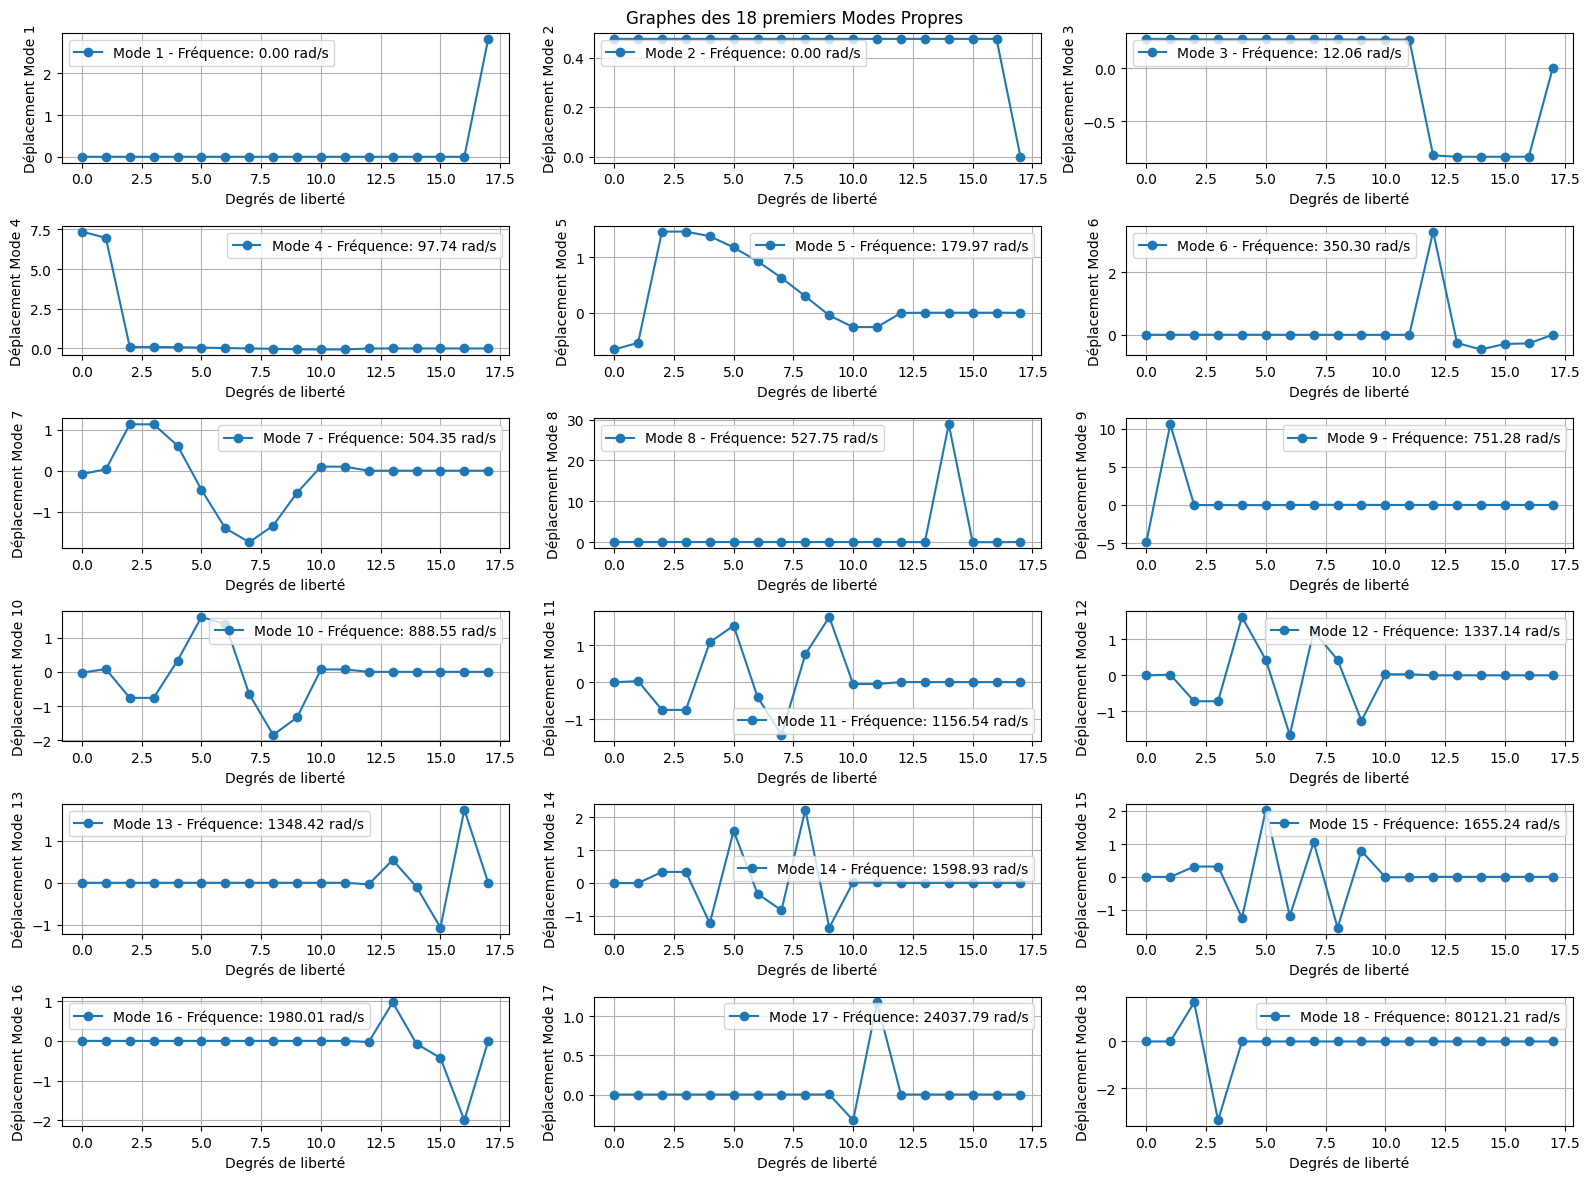

In [39]:
#DeformeeModale(J, K)
tracerNModesPropres(J, K, 18)


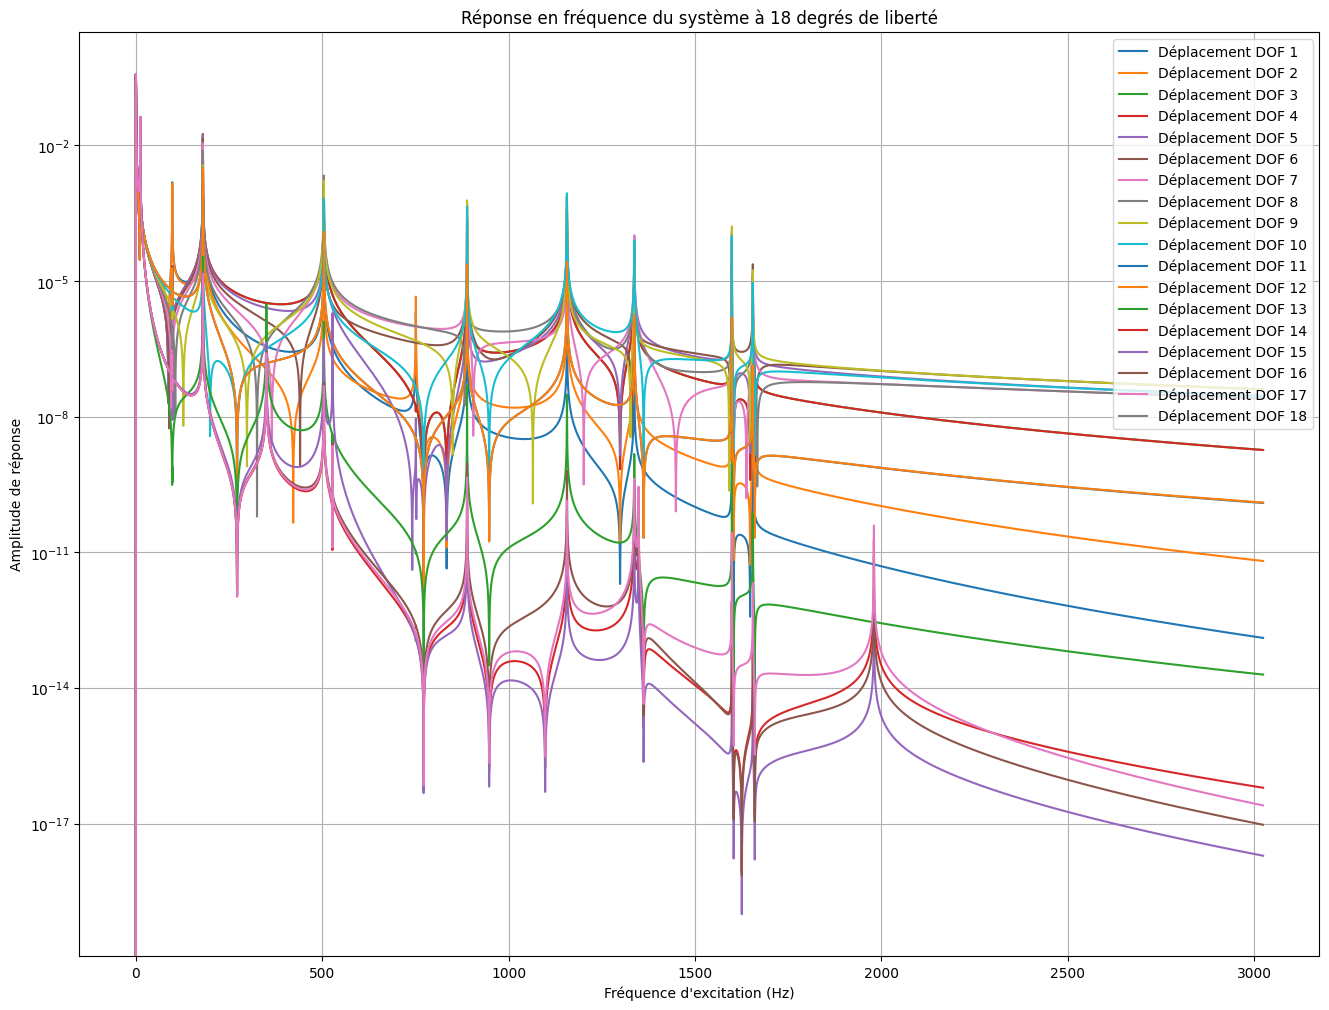

In [40]:
frequencies_rad_s = np.linspace(0, 19000, 10000)
    
# Calcul de la réponse en fréquence
response_magnitude = calculer_reponse_frequence(J, K, F, frequencies_rad_s)

# Tracer la réponse en fréquence
tracer_N_reponse_frequence(response_magnitude, frequencies_rad_s, 18)